In [62]:
### Import packages to create absolute file path & make code independent of operating system

from pathlib import Path
import os.path

import warnings
warnings.filterwarnings("ignore")

### Import packages for data manipulation

import pandas as pd
import numpy as np
import re

### Import packages to visualize data

import matplotlib.pyplot as plt
import seaborn as sns

### Import packages for feature extraction

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

### Import packages for modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Import packages for model selection and performance assessment
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, mean_squared_error, f1_score

In [26]:
### Read in dataset

print(os.getcwd())

base_path = Path("__file__").parent
full_path = (base_path / "../../data/processed/stackoverflow_preprocessed.csv").resolve()
# Depending on running this in interactive shell vs. terminal, I need to include GitHub/FrauenLoop_NLP_Project_2020 in filepath or not...

stackoverflow = pd.read_csv(os.path.join(full_path))

/Users/HenriekeMax/Documents/Career_Development/GitHub/FrauenLoop_NLP_Project_2020/src/features


In [ ]:
stackoverflow = pd.read_csv("/Users/HenriekeMax/Documents/Career_Development/GitHub/FrauenLoop_NLP_Project_2020/data/processed/stackoverflow_preprocessed.csv")

In [27]:
### Print out dataset for overview

stackoverflow.head()

,Unnamed: 0,score,question_title,question_text,answer_count,comment_count,creation_date,favorite_count,tags,view_count,answer_text,score_cat,question_title_clean,question_text_clean,tags_clean,answer_text_clean,answer_wordcount
0,0,0,How to avoid Bot repeating command in groups?,<p>I created a new Telegram Bot which maintain...,2,0,2019-08-23 14:05:29.463000+00:00,0.0,telegram-bot|python-telegram-bot,79,"<p>The bot only is replying message, not creat...",bad,avoid bot repeat command group,create new telegram bot maintain simple list c...,telegrambot pythontelegrambot,bot reply message create message use sendmessage,7
1,1,-3,how to host Asp.net core web application..?,<p>I have more confusion with hosting my appli...,2,0,2020-04-27 22:38:03.737000+00:00,NaN,asp.net-core|shared-hosting|cloud-hosting,47,<p>If choose their windows cloud hosting platf...,bad,host asp net core web application,confusion host application build application a...,asp netcore sharedhosting cloudhosting,choose window cloud host platform net core wor...,22
2,2,0,discord.ext.commands.errors.MissingRequiredArg...,<p>i would like make a command for set permiss...,2,0,2020-02-21 01:10:53.553000+00:00,NaN,discord.py|discord.py-rewrite,103,"<p>What you're doing right now, is <strong>req...",bad,discord ext command error missingrequiredargum...,would like make command set permission text ch...,discord py discord pyrewrite,right now require guild argument command bot a...,92
3,3,0,JPA not saving to DB on WildFly 16,<p>After migrating from Wildfly-8.2.0 to Wildf...,1,1,2019-11-03 23:51:01.683000+00:00,NaN,jpa|jakarta-ee|persistence|jpa-2.1|wildfly-16,22,"<p>What was missing is to add the ""eclipselink...",bad,jpa save db wildfly,migrate wildfly wildfly jee application launch...,jpa jakartaee persistence jpa wildfly,miss add eclipselink jar file wildfly module s...,34
4,4,0,Conditionally rendering an array within an arr...,<p>I've tried many of the methods outlined by ...,1,5,2020-02-23 03:24:42.360000+00:00,NaN,javascript|html|reactjs,40,<p>You need to trigger a re-render. This is do...,bad,conditionally render array within array within...,ive try many method outline user dice im sure ...,javascript html reactjs,need trigger rerender do call tell content com...,82


In [28]:
### Print out variable types for overview

stackoverflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            30000 non-null  int64  
 1   score                 30000 non-null  int64  
 2   question_title        30000 non-null  object 
 3   question_text         30000 non-null  object 
 4   answer_count          30000 non-null  int64  
 5   comment_count         30000 non-null  int64  
 6   creation_date         30000 non-null  object 
 7   favorite_count        13550 non-null  float64
 8   tags                  30000 non-null  object 
 9   view_count            30000 non-null  int64  
 10  answer_text           30000 non-null  object 
 11  score_cat             30000 non-null  object 
 12  question_title_clean  29999 non-null  object 
 13  question_text_clean   30000 non-null  object 
 14  tags_clean            29707 non-null  object 
 15  answer_text_clean  

In [29]:
### Figure out how to deal with missing values for answer_text_clean, tags_clean and question_title_clean

stackoverflow.isna().any()

Unnamed: 0              False
score                   False
question_title          False
question_text           False
answer_count            False
comment_count           False
creation_date           False
favorite_count           True
tags                    False
view_count              False
answer_text             False
score_cat               False
question_title_clean     True
question_text_clean     False
tags_clean               True
answer_text_clean        True
answer_wordcount        False
dtype: bool

In [30]:
stackoverflow = stackoverflow.drop(['favorite_count'] , axis=1)

In [31]:
### Drop all observations / rows with any missing values

stackoverflow = stackoverflow.dropna()

In [32]:
### Define function to count number of words in an answer

def wordcounter(x):
    x = len(re.findall(r'\w+', str(x)))
    return x

In [33]:
### Feature extraction: Get wordcount of stackoverflow answers

stackoverflow['answer_wordcount'] = stackoverflow['answer_text_clean'].apply(wordcounter)

In [34]:
### Check of possible patterns in wordcount and answer score

stackoverflow.groupby(['score_cat', 'answer_wordcount']).size().unstack(fill_value=0)

answer_wordcount,1,2,3,4,5,6,7,8,9,10,...,1337,1364,1449,1490,1521,1668,1919,1933,2019,2108
score_cat,,,,,,,,,,,,,,,,,,,,,
bad,10,23,35,62,59,78,97,119,136,135,...,1,0,0,0,0,1,1,0,0,0
good,5,16,24,38,53,71,110,93,103,131,...,0,1,1,0,1,0,0,0,1,1
great,10,15,48,79,87,123,129,139,181,165,...,0,0,0,1,0,0,0,1,0,0


In [35]:
### Make score_cat column into type category and assign numeric category codes

stackoverflow['score_cat'] = stackoverflow['score_cat'].astype('category')
stackoverflow['score_cat'] = stackoverflow.score_cat.cat.codes
stackoverflow_copy = stackoverflow.copy()

### Make integer to be able to show heatmap in next step

stackoverflow_copy['score_cat_int'] = stackoverflow_copy.score_cat.astype(int)

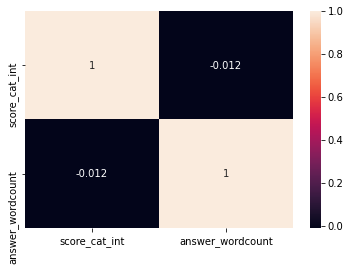

In [36]:
### Heatmap to check relationship of score_cat and answer_wordcount

df = pd.DataFrame(stackoverflow_copy, columns=['score_cat_int', 'answer_wordcount'])
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [37]:
### Creating a binary feature "code" holding info on whether or not stackoverflow answer contains code
def codecheck(x):
    x = 1 if '<code>' in x else 0
    return x

In [40]:
### Check of possible patterns in code existence and answer score

stackoverflow['code_binary'] = stackoverflow['answer_text'].apply(codecheck)
stackoverflow['code_binary'].value_counts()

1    24144
0     5550
Name: code_binary, dtype: int64

In [39]:
### Check of possible patterns in code existence and answer score

stackoverflow.groupby(['score_cat', 'code_binary']).size().unstack(fill_value=0)

code_binary,0,1
score_cat,,
0,1888,7972
1,1642,8229
2,2020,7943


In [41]:
### Creating a feature "code count" holding info on how many code-snippets an answer contains

def codecount(x):
    x = x.count("<code>")
    return x

In [42]:
### Check of possible patterns in number of code snippets and answer score

stackoverflow['code_count'] = stackoverflow['answer_text'].apply(codecount)
stackoverflow.groupby(['score_cat', 'code_count']).size().unstack(fill_value=0)

code_count,0,1,2,3,4,5,6,7,8,9,...,69,70,73,74,77,80,85,88,101,102
score_cat,,,,,,,,,,,,,,,,,,,,,
0,1888,2750,1727,1025,699,488,317,244,165,127,...,1,0,0,0,0,1,0,0,0,0
1,1642,2547,1713,1077,711,546,378,280,208,134,...,0,1,0,0,0,0,1,1,0,0
2,2020,3429,1709,950,553,297,272,160,112,85,...,0,0,1,1,2,0,0,0,1,1


In [43]:
### Split into predictors and outcome data

y = stackoverflow['score_cat']
X = stackoverflow.drop(['score_cat', 'score', 'answer_count', 'comment_count', 'creation_date', 'view_count'] , axis=1)

In [44]:
y.dtype

dtype('int8')

In [45]:
### Compute n grams from a dataframe for a given variable

class Ngrams(BaseEstimator, TransformerMixin):

    def __init__(self, df):
        pass

    def transform(self, df):
        ### Save name of variable to analyze
        name = df.columns
        #### Initiate TfidfVectorizer
        vectorizer = TfidfVectorizer(strip_accents = 'unicode', use_idf = True, \
                                     stop_words = 'english', analyzer = 'word', \
                                     ngram_range = (1, 1), max_features = 100) 
                                     # if I remove max_features, I get error that array shape X and Y do not align

        ### Fit to data
        X_train = vectorizer.fit_transform(df[name[0]].values.astype(str))
        ## X_train = X_train.toarray()
        # is this needed? how do I address mismatching shape problem

        ### Return sparse matrix
        return X_train
    
    def fit(self, df, y=None):
        ### Unless error returns self
        return self

In [46]:
### Split into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [47]:
print(y_test)

15451    1
10261    1
28352    2
20142    2
8401     0
        ..
27931    2
315      0
13704    1
25463    2
7465     0
Name: score_cat, Length: 8909, dtype: int8


In [48]:
### Model selection process: Create list of different classifiers/algorithms to try out

classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=1),
    GradientBoostingClassifier(random_state=1)
    ## XGBClassifier(random_state=1)
    ]

In [74]:
### Model selection process: Loop through the different classifiers using the pipeline

for classifier in classifiers:
    model_pipeline = Pipeline([
        ('feats', FeatureUnion([
             # Ngrams
            ('ngram_all', Ngrams(X_train[['answer_text_clean']]))])),
            # Classifier
            ('classifier', classifier)])
    model_pipeline.fit(X_train, y_train)
    y_predict = model_pipeline.predict(X_test)
    print(classifier)
    print(y_predict)
    print(metrics.classification_report(y_test, y_predict))

    # map predictions on to dataframe, then create a column if prediction correct and understand false predictions
    # which samples from great answers have been predicted bad
    # which samples from bad answers have been predicted great?

KNeighborsClassifier()
[2 2 2 ... 2 2 2]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3025
           1       1.00      0.00      0.00      2964
           2       0.33      1.00      0.49      2920

    accuracy                           0.33      8909
   macro avg       0.44      0.33      0.16      8909
weighted avg       0.44      0.33      0.16      8909

RandomForestClassifier(random_state=1)
[1 2 2 ... 2 2 2]
              precision    recall  f1-score   support

           0       0.74      0.01      0.02      3025
           1       0.87      0.01      0.02      2964
           2       0.33      1.00      0.50      2920

    accuracy                           0.33      8909
   macro avg       0.65      0.34      0.18      8909
weighted avg       0.65      0.33      0.17      8909

GradientBoostingClassifier(random_state=1)
[1 2 2 ... 2 2 2]
              precision    recall  f1-score   support

           0       0.74 

In [ ]:

## confusion_matrix(y_test, grid_search.predict(X_test))

  # confm_hold = confusion_matrix(y_test, y_predict)
    # print(confm_hold)

# np.array(s)
## confm_hold_df = pd.DataFrame(confm_hold, index = ['No Medal', 'Medal'],
                               # columns = ['No Medal', 'Medal'])
## plt.figure(figsize=(5,4))
## sns.heatmap(confm_hold_df, annot=True, fmt=".4f", linewidths=.5, square = True)

In [ ]:
### Pipe different features in with a name so the step can be later called for details

pipeline = Pipeline([
    ('feats', FeatureUnion([
        # Ngrams
        ('ngram_all', Ngrams(X_train[['answer_text_clean']]))
    ])),
     # Classifier
     ('kneighbors', KNeighborsClassifier(n_neighbors=5, leaf_size=40))])

In [ ]:
### Cross validation and tuning
from sklearn.model_selection import GridSearchCV
param_grid = {'kneighbors__n_neighbors': (3, 5, 10),
            'kneighbors__leaf_size': (10, 20 , 30),
            'kneighbors__p': (1,2)
            }

In [ ]:
### Find best model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, iid=False, n_jobs=-1, refit = True)
grid_search.fit(X_train, y_train)

In [ ]:
### Print best model
print("Best score:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

print(classification_report(y_test, grid_search.predict(X_test)))

In [ ]:
### To Do

# Finalize cleaner function (whitespaces etc.)
# Additional features, e.g.
    ### Figure out no. of switches from code to explanation
    ### Extract tags into separate columns and one-hot-encode

# Play with different ngram (1,2,3) and max feature numbers
# Incorporate functions/call them in pipeline
# Try out different models
# Hypertune model